# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

In [314]:
# I like all my imports to be in one place
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

In [316]:
# load in the dataset
df=pd.read_csv('data/cars_hw.csv')
df=df.drop(columns={'Unnamed: 0'})
df.head()

,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [318]:
# removing rows with NaN values, seems like rows with NaN are NaN all across
#print(df[df.isnull()])
df=df.dropna(axis=0)
for i in df:
    print(i)
    print(f'{df[i].unique()}\n\n')
df2=df.copy()

Make
['Volkswagen' 'Hyundai' 'Honda' 'Renault' 'Tata' 'Chevrolet'
 'Maruti Suzuki' 'Toyota' 'Mahindra' 'Ford' 'Nissan' 'Jeep' 'MG Motors'
 'Kia' 'Skoda' 'Datsun']


Make_Year
[2017 2016 2019 2012 2021 2020 2013 2022 2018 2014 2011 2015]


Color
['silver' 'red' 'white' 'bronze' 'orange' 'grey' 'blue' 'yellow' 'beige'
 'brown' 'golden' 'black' 'maroon' 'purple' 'green']


Body_Type
['sedan' 'crossover' 'suv' 'hatchback' 'muv']


Mileage_Run
[44611 20305 29540 35680 25126 52261 28108 92603 16304 26350 35400 71450
 32395 15059 31994 13768  3174 70137 35913 19056 32492 22598 85981 17791
 26910 28562 40345 19550 54233 33113 79565 10651 27664 13389 30797 48947
 37315 11047 24858  4839 16329 57286  3679 96077 30406 60873 24811 56275
 78981  7434 10730 21996  3474 64458 24360 69939 35387 63035 26190 47013
 11734 27902 66674 38143 13554  1540 12285 80408 83377 21887 40498 18065
 70958 16090 55617 87773 54744 18915 97573  4776 24676 52291 49775 83551
 34075 14414 35796 38199  8197 27626 48106 120

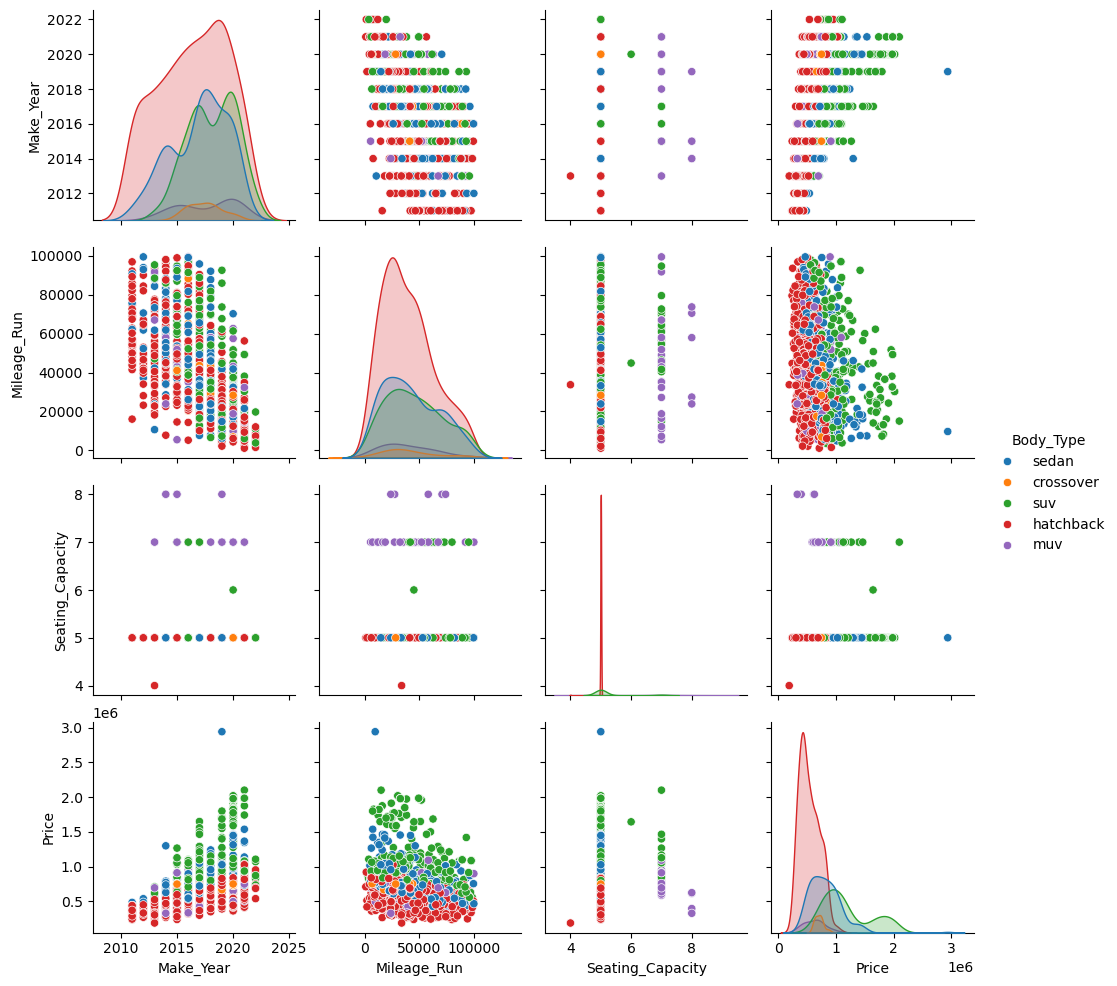

In [320]:
#sns.pairplot(df, kind='kde',palette='magma')

sns.pairplot(df, diag_kind="kde", hue='Body_Type')

#sns.pairplot(df, hue='Make')
#sns.pairplot(df, hue='Color')
#sns.pairplot(df, hue='No_of_Owners')
#sns.pairplot(df, hue='Fuel_Type')
#sns.pairplot(df, hue='Transmission')
#sns.pairplot(df, hue='Transmission_Type')

# It seems like there are significant correlations between variable pairs Price/Make_Year and a natural
# separation of data on the Body_Type variable

In [321]:
# One-hot encode for categorical nominal variables
df=df2.copy()
df=pd.get_dummies(df, columns=['Make'], drop_first=True)
df=pd.get_dummies(df, columns=['Color'], drop_first=True)
df=pd.get_dummies(df, columns=['Body_Type'], drop_first=True)
df=pd.get_dummies(df, columns=['Fuel_Type'], drop_first=True)
df=pd.get_dummies(df, columns=['Transmission_Type'], drop_first=True)

df3=df.copy()
df.head()

,Make_Year,Mileage_Run,No_of_Owners,Seating_Capacity,Transmission,Price,Make_Datsun,Make_Ford,Make_Honda,Make_Hyundai,...,Color_silver,Color_white,Color_yellow,Body_Type_hatchback,Body_Type_muv,Body_Type_sedan,Body_Type_suv,Fuel_Type_petrol,Fuel_Type_petrol+cng,Transmission_Type_Manual
0,2017,44611,1st,5,7-Speed,657000,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,2016,20305,1st,5,5-Speed,682000,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
2,2019,29540,2nd,5,5-Speed,793000,False,False,True,False,...,False,True,False,False,False,False,True,True,False,True
3,2017,35680,1st,5,5-Speed,414000,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
4,2017,25126,1st,5,5-Speed,515000,False,False,False,True,...,False,False,False,True,False,False,False,True,False,True


In [322]:
# Transformation of categorical nominal variables 
df=df3.copy()

owner_mapping = {'1st': 1, '2nd': 2, '3rd': 3}
df['No_of_Owners'] = df['No_of_Owners'].map(owner_mapping)

transmission_mapping = {'4-Speed': 4, '5-Speed': 5, '6-Speed': 6, '7-Speed': 7, 'CVT': 5} 
df['Transmission'] = df['Transmission'].map(transmission_mapping)
# CVT mapped to a middle value bc apparently it is often compared to 5-Speed

df.head()

,Make_Year,Mileage_Run,No_of_Owners,Seating_Capacity,Transmission,Price,Make_Datsun,Make_Ford,Make_Honda,Make_Hyundai,...,Color_silver,Color_white,Color_yellow,Body_Type_hatchback,Body_Type_muv,Body_Type_sedan,Body_Type_suv,Fuel_Type_petrol,Fuel_Type_petrol+cng,Transmission_Type_Manual
0,2017,44611,1,5,7,657000,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,2016,20305,1,5,5,682000,False,False,False,True,...,False,False,False,False,False,False,False,True,False,True
2,2019,29540,2,5,5,793000,False,False,True,False,...,False,True,False,False,False,False,True,True,False,True
3,2017,35680,1,5,5,414000,False,False,False,False,...,False,False,False,True,False,False,False,True,False,True
4,2017,25126,1,5,5,515000,False,False,False,True,...,False,False,False,True,False,False,False,True,False,True


In [323]:
# 'Price' as the target variable
X = df.drop(columns=['Price'])  # Features
y = df['Price']  # Target variable

# Split into 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [324]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 'Price' as the target variable
X = df.drop(columns=['Price'])  # Features
y = df['Price']  # Target variable

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select individual features for simple linear models
feature_list = ['Make_Year', 'Mileage_Run', 'No_of_Owners', 'Seating_Capacity',
       'Transmission', 'Make_Datsun', 'Make_Ford', 'Make_Honda',
       'Make_Hyundai', 'Make_Jeep', 'Make_Kia', 'Make_MG Motors',
       'Make_Mahindra', 'Make_Maruti Suzuki', 'Make_Nissan', 'Make_Renault',
       'Make_Skoda', 'Make_Tata', 'Make_Toyota', 'Make_Volkswagen',
       'Color_black', 'Color_blue', 'Color_bronze', 'Color_brown',
       'Color_golden', 'Color_green', 'Color_grey', 'Color_maroon',
       'Color_orange', 'Color_purple', 'Color_red', 'Color_silver',
       'Color_white', 'Color_yellow', 'Body_Type_hatchback', 'Body_Type_muv',
       'Body_Type_sedan', 'Body_Type_suv', 'Fuel_Type_petrol',
       'Fuel_Type_petrol+cng', 'Transmission_Type_Manual']

results = []

for feature in feature_list:
    X_train_feat = X_train[[feature]]
    X_test_feat = X_test[[feature]]

    model = LinearRegression()
    model.fit(X_train_feat, y_train)

    y_train_pred = model.predict(X_train_feat)
    y_test_pred = model.predict(X_test_feat)

    # RMSE and R^2
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        'Feature': feature,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train R²': train_r2,
        'Test R²': test_r2
    })

results_df = pd.DataFrame(results)

# Sort by RMSE (the lower the better)
results_df_sorted_rmse = results_df.sort_values(by='Test RMSE', ascending=True)
print(results_df_sorted_rmse,'\n')

# Sort by R^2 (the higher the better)
results_df_sorted_r2 = results_df.sort_values(by='Test R²', ascending=False)
print(results_df_sorted_r2)

# The Body-Type model performed better---just as I predicted using the pairplot! 

                     Feature     Train RMSE      Test RMSE  Train R²   Test R²
37             Body_Type_suv  291469.402555  284056.528398  0.391359  0.296501
34       Body_Type_hatchback  309127.403136  285406.592139  0.315379  0.289798
0                  Make_Year  317443.710381  288232.563579  0.278048  0.275664
4               Transmission  314059.496631  289201.114434  0.293359  0.270788
11            Make_MG Motors  297080.179240  290129.429687  0.367701  0.266099
13        Make_Maruti Suzuki  360775.553185  322239.761008  0.067499  0.094660
38          Fuel_Type_petrol  342267.801316  326774.385251  0.160720  0.069000
1                Mileage_Run  369437.232061  330349.982458  0.022186  0.048514
40  Transmission_Type_Manual  368872.282741  331520.644945  0.025174  0.041759
10                  Make_Kia  364675.293415  332809.684349  0.047231  0.034293
20               Color_black  370184.724586  333757.634404  0.018225  0.028783
17                 Make_Tata  370970.713939  334772.

   Make_Year  Mileage_Run  Seating_Capacity     Price
0   0.013092     0.124692          -0.21365 -0.228852
1  -0.341858    -0.872334          -0.21365 -0.160757
2   0.722993    -0.493517          -0.21365  0.141584
3   0.013092    -0.241655          -0.21365 -0.890733
4   0.013092    -0.674578          -0.21365 -0.615630


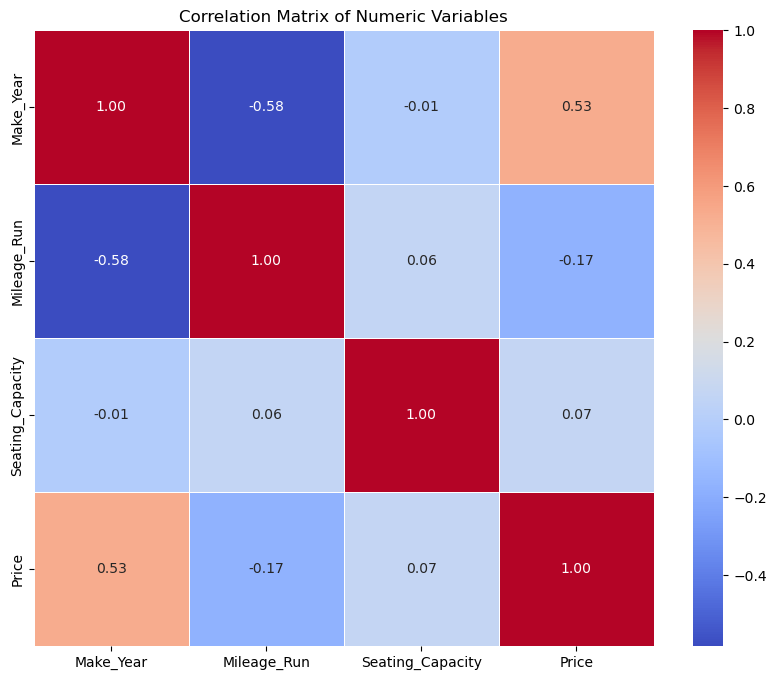

In [325]:
df=df2.copy()
#print(df.dtypes)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Standardize numeric columns---learned about this in DS4002 (hopefully implementing it right here)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_columns])

df_scaled = pd.DataFrame(df_scaled, columns=numeric_columns)
print(df_scaled.head())

correlation_matrix = df_scaled.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Numeric Variables")
plt.show()

In [326]:
# Log Transformation for skewed data
X_train['Log_Make_Year'] = np.log1p(X_train['Make_Year'])  # It seems (from pairplot) that Make_year is a bit skewed
X_test['Log_Make_Year'] = np.log1p(X_test['Make_Year'])

# Interaction terms---to my best knowledge are interacting
X_train['Mileage_Run_Year'] = X_train['Mileage_Run'] * X_train['Make_Year']
X_test['Mileage_Run_Year'] = X_test['Mileage_Run'] * X_test['Make_Year']

X_train['No_Owners_Transmission'] = X_train['No_of_Owners'] * X_train['Transmission']
X_test['No_Owners_Transmission'] = X_test['No_of_Owners'] * X_test['Transmission']

# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Fit linear regression model & Predict
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Compute RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Compute R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Results 😰
print(f"Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
print(f"Train R^2: {train_r2:.4f}, Test R^2: {test_r2:.4f}")

Train RMSE: 142357.63, Test RMSE: 143531.88
Train R^2: 0.8548, Test R^2: 0.8204


I first cleaned the data, handled any missing values, and did some basic EDA. I checked out the summary stats, plotted some distributions, and looked for any clear relationships between the features and price. I then transformed the categorical variables using one-hot encoding for the nominal ones and mapped ordinal variables like 'No_of_Owners' to numbers.

Next, I did the classic 80/20 train-test split, keeping 80% for training and 20% for testing. I built simple linear regression models for each feature and checked how well they did using RMSE and R^2 on both training and test sets. Some features like 'Body_Type_suv' and 'Make_Year' did better than others like 'Color' or 'Seating_Capacity.'

I also made partial correlation plots for the numeric variables, but didn’t spot any major non-linearities. Afterward, I added some transformations and interactions to the models, and they definitely performed better than the simple ones. The more complex models gave me more accurate predictions overall.

As for model selection, I found that simpler models tended to underfit the data, especially with features that didn’t have strong predictive power like 'Color.' On the other hand, the more complex models seemed to fit the training data really well but had a better balance on the test set, reducing the risk of overfitting. So, picking the right model really depends on the trade-off between simplicity and performance, making sure you don't overcomplicate things but also don’t miss out on important interactions and transformations.